In [1]:
from pyzotero import zotero
import os
import sys
from dotenv import load_dotenv
load_dotenv()
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
tqdm.pandas()

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from code_utils.zotero import get_data_from_zotero
from code_utils.glutton import get_doi_glutton
from code_utils.utils import get_doi_cleaned,aplatir
from code_utils.pickle import load_cache,write_cache
from code_utils.enriching_data_OpenAlex import get_countries_concepts_sdg,get_open_alex_data,get_publi_not_in_ipcc

In [2]:
cached_openalex_data_ipbes = {}
cached_openalex_data_not_ipbes = {}

In [3]:
try:
    cached_openalex_data_ipbes = load_cache(cached_openalex_data_ipbes,module_path+'\\IPCC_bibliography\\AR6\\structured_data\\cached_openalex_data_ipbes.pkl')
    cached_openalex_data_not_ipbes = load_cache(cached_openalex_data_ipbes,module_path+'\\IPCC_bibliography\\AR6\\structured_data\\cached_openalex_data_not_ipbes.pkl')
except:
    write_cache(cached_openalex_data_ipbes,module_path+'\\IPCC_bibliography\\AR6\\structured_data\\cached_openalex_data_ipbes.pkl')
    write_cache(cached_openalex_data_ipbes,module_path+'\\IPCC_bibliography\\AR6\\structured_data\\cached_openalex_data_not_ipbes.pkl')

6606 data in cached openalex data


Read IPBES references in zotero files

In [4]:
ZOTERO_KEY = os.getenv('ZOTERO_KEY')
IPBES_ZOTERO_ID = '2333077'
COLLECTION_IDS = ['8DQ8YFJI','JR5LKU4U','LBFNF62B','7IMYH9U3','DRZLUY9K','KTPTCAVF','UWNSUNXQ','BJGWRJAK','JT8FJXP6']
CHAPTER_IDS=['1','2.1','2.2','2.3','3','4','5','6','glossary']
ALL_COLLECTIONS={}

In [5]:
ALL_COLLECTIONS=get_data_from_zotero(ZOTERO_KEY,IPBES_ZOTERO_ID,COLLECTION_IDS,CHAPTER_IDS,ALL_COLLECTIONS)

In [6]:
df_ipbes_chap={}
for i in range(len(COLLECTION_IDS)):
    df_ipbes_chap[CHAPTER_IDS[i]]=pd.DataFrame(list(pd.DataFrame(ALL_COLLECTIONS[f'collection_chapter_{CHAPTER_IDS[i]}']).data))[['DOI','title','date','creators','tags']]
    df_ipbes_chap[CHAPTER_IDS[i]]['chap']=f'chap_{CHAPTER_IDS[i]}'
    print(f'{len(df_ipbes_chap[CHAPTER_IDS[i]][~pd.isna(df_ipbes_chap[CHAPTER_IDS[i]].DOI)])/len(df_ipbes_chap[CHAPTER_IDS[i]])*100} % doi available for chapter {CHAPTER_IDS[i]}')

63.2258064516129 % doi available for chapter 1
71.26436781609196 % doi available for chapter 2.1
79.26829268292683 % doi available for chapter 2.2
79.60199004975125 % doi available for chapter 2.3
81.64682539682539 % doi available for chapter 3
85.9103385178408 % doi available for chapter 4
73.2587064676617 % doi available for chapter 5
81.23682361208714 % doi available for chapter 6
37.90613718411552 % doi available for chapter glossary


Clean and enrich data 

In [24]:
df_ipbes=pd.concat(list(df_ipbes_chap.values())).reset_index()
del df_ipbes['index']

In [25]:
len(df_ipbes[~pd.isna(df_ipbes.DOI)])/len(df_ipbes)*100

77.36948241093435

In [26]:
df_ipbes.loc[pd.isna(df_ipbes.DOI),'DOI']=df_ipbes.loc[pd.isna(df_ipbes.DOI),:].progress_apply(get_doi_glutton, axis=1)

  0%|          | 0/2020 [00:00<?, ?it/s]

In [27]:
len(df_ipbes[~pd.isna(df_ipbes.DOI)])/len(df_ipbes)*100

89.28971543804616

In [28]:
df_ipbes.loc[:,'DOI']=df_ipbes.loc[:,'DOI'].apply(lambda x: get_doi_cleaned(x))
df_ipbes.loc[:,'DOI']=df_ipbes.loc[:,'DOI'].apply(lambda x: None if str(x)[:4]=='http' else x)
df_ipbes['freq']=1
df_ipbes=df_ipbes.rename(columns={'DOI':'doi'})

Enriching data through OpenAlex API integration

In [14]:
df_unique_doi=df_ipbes.groupby(by=['doi'], dropna=True).agg({'chap': lambda x: list(x), 'freq': 'sum'})
df_unique_doi=df_unique_doi.reset_index()

In [15]:
#get data_OpenAlex from the API 
df_unique_doi.apply(lambda row: get_open_alex_data(cached_openalex_data_ipbes,row['doi']), axis= 1)
write_cache(cached_openalex_data_ipbes,module_path+'\\IPCC_bibliography\\AR6\\structured_data\\cached_openalex_data_ipbes.pkl')

In [16]:
year_list = []
countries_list = []
concepts_list = []
sdg_list = []
for i,row in df_unique_doi.iterrows():
    countries,concepts,sdg,year=get_countries_concepts_sdg(cached_openalex_data_ipbes,row)

    countries_list.append(countries)
    concepts_list.append(concepts)
    sdg_list.append(sdg)
    year_list.append(year)   

df_unique_doi['countries'] = countries_list
df_unique_doi['concepts'] = concepts_list
df_unique_doi['sdg'] = sdg_list
df_unique_doi['year'] = year_list

Visualization of the contribution of each countries in ipcc references

In [17]:
df_unique_doi=df_unique_doi[['doi','countries','concepts','sdg','chap','year']]

In [29]:
df_ipbes=pd.merge(df_ipbes, df_unique_doi[['doi','countries','concepts','sdg','year']], on='doi', how='left')
df_ipbes.loc[:,'countries']=df_ipbes.loc[:,'countries'].apply(lambda x: str(x).replace('nan','None').replace('[]','None').replace('[None]','None') if ((str(x)=='nan')|(str(x)=='[None]')|((str(x)=='[]'))) else x )
df_ipbes.loc[:,'countries']=df_ipbes.loc[:,'countries'].apply(lambda x: ['None'] if x=='None' else x)

In [30]:
data_counts = pd.Series(aplatir(list(df_ipbes['countries']))).value_counts().drop('None')

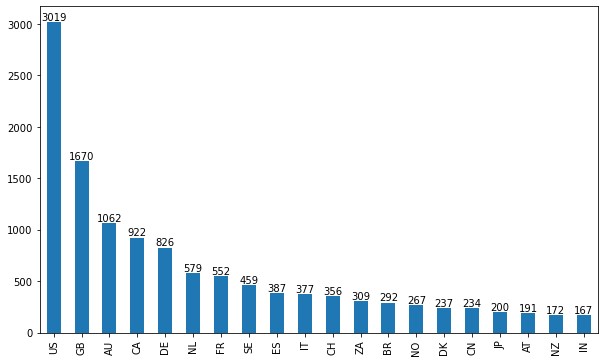

In [31]:
plt.figure(figsize=(10, 6))
data_counts[:20].plot(kind='bar')
ax = data_counts[:20].plot(kind='bar')
for i, v in enumerate(data_counts[:20]):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom')
plt.show()

Find the data for constructing the learning model ( IPBES related or not )

In [37]:
df_ipbes[df_ipbes['chap']=='chap_4'].year.max()

2022.0

In [33]:
df_ipbes['year'] = pd.to_numeric(df_ipbes['year'], errors='coerce')
year=df_ipbes.drop_duplicates(subset='doi')['year'].dropna().sort_values().apply(lambda x: int(x))
year_counts = pd.Series(list(year)).value_counts().to_dict()

In [34]:
dois=list(df_unique_doi.doi)

In [35]:
dict_year={}
year_counts_not_ipbes={}

In [ ]:
while sum(list(year_counts_not_ipbes.values()))<(len(dois)):
    print(sum(list(year_counts_not_ipbes.values())))
    get_publi_not_in_ipcc(dois,dict_year,year_counts,year_counts_not_ipbes)

In [ ]:
pd.DataFrame(aplatir(list(dict_year.values()))).to_json(module_path+f'\\IPCC_bibliography\\AR6\\structured_data\\data_not_ipbes.jsonl', orient= 'records', lines= True)